In [0]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset

from torchvision.transforms import ToTensor, ToPILImage, Normalize, Compose
import tarfile

import pandas as pd
from zipfile import ZipFile
import io
import cv2 
import os
from google.colab import files
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import *

from PIL import Image
from io import BytesIO

In [0]:
def count_parameters(model):
    #for parameter in model.parameters():
    #    print(parameter)
    #print ('nb of trainable parameters')
    return (sum([p.numel() for p in model.parameters() if p.requires_grad]))

In [22]:
file_name = "Output_seuillage.zip"
path_csv = '/content/Output_seuillage/small_training_dataset.csv'

with ZipFile(file_name, 'r') as zip:
  zip.extractall();
  print('done')
csv = pd.read_csv(path_csv)
csv.columns = [c.replace(' ', '_') for c in csv.columns]

done


In [23]:
print(csv.index.values)
print(csv.ID.values)
test = {}
i = 0
for row in csv.species.values:
  if row not in test:
    test[row] = i
    i = i + 1
print(test)
print(test.get('Populus nigra'))
print(list(test.keys())[list(test.values()).index(1)]) 


[0 1 2 3 4 5 6 7 8]
[12257 21288 22548  2725 32095  3345 36038 36244  4939]
{'Syringa vulgaris': 0, 'Populus nigra': 1}
1
Populus nigra


In [0]:
class ImageDataset(Dataset):
  def __init__(self, txt_path='/content/Output_seuillage/small_training_dataset.csv'
, img_dir='/content/Output_seuillage/', transform=None, test=False):
     # initialize variables such is path to csv file and images and transforms
    df = pd.read_csv(txt_path)
   
    categories = {}
    i = 0
    for row in df.species.values:
      if row not in categories:
        categories[row] = i
        i = i + 1
    self.categories = categories
    self.img_names = df.ID.values
    self.format_img = '.jpg'
    self.species = df.species.values
    self.txt_path = txt_path
    self.img_dir = img_dir
    self.transform = transform
    self.to_tensor = ToTensor()
    self.to_pil = ToPILImage()

    self.get_image_selector = True if img_dir.__contains__('tar') else False
    self.tf = tarfile.open(self.img_dir) if self.get_image_selector else None
    self.transform_gt = transform if test else Compose(self.transform.transforms[:-1])  # omit noise of ground truth
    
    print("dataset initialise")
  def __len__(self):
      # here you just need to return a single integer number as the length of your dataset, in your 
      #  case, number of images in your train folder or lines in csv file
    return len(self.img_names)
      #return 1;
  def get_image_from_folder(self, name):
        """
        gets a image by a name gathered from file list text file
        :param name: name of targeted image
        :return: a PIL image
        """
        image_name = os.path.join(self.img_dir, str(name))
        image_name =image_name + str(self.format_img)
        image = Image.open(image_name)
        #image = plt.imread(image_name)
        
        trans1 = transforms.ToTensor()
      
        return trans1(image)
  def getTarget(self, index):
    return self.categories.get(self.species[index])
  def getNameSpecies(self, idDictionary):
    return list(test.keys())[list(test.values()).index(idDictionary)]
  def show(self, index):
    trans = transforms.ToPILImage()
    img = self.get_image_from_folder(self.img_names[index])
    plt.imshow(trans(img))
  def __getitem__(self, index): 
    if index == (self.__len__() - 1) and self.get_image_selector:  # close tarfile opened in __init__
              self.tf.close()
    
    print(self.img_names[index])
    img = self.get_image_from_folder(self.img_names[index])
    #spc = self.species[index]
    spc = self.getTarget(index)
    
    sample = (img, spc)
    

    return sample


dataset initialise
Reduced Dataset
Number of samples:  9
2725
tensor(0.)
tensor(1.)
Image Size:  torch.Size([1, 28, 28])
0


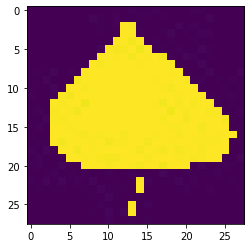

In [25]:
custom_transforms = Compose([ ToTensor()])
train_dataset = ImageDataset(txt_path='/content/Output_seuillage/small_training_dataset.csv',
                              img_dir='/content/Output_seuillage/',
                              transform= custom_transforms,
                              test=False)

print('Reduced Dataset')
print('Number of samples: ', len(train_dataset))
img, target = train_dataset[3] # load 4th sample
print(img.min())
print(img.max())


print("Image Size: ", img.size())
print(target)
train_dataset.show(3)



In [0]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
#structure de pytorch facilitant l acces a une base de donnée
testloader  = torch.utils.data.DataLoader(train_dataset,  batch_size=64, shuffle=True, num_workers=2)

In [0]:
class MLPNet(nn.Module):
    def __init__(self,s):
        super(MLPNet, self).__init__()
        self.name = 'mlp'
        self.s    = s
        self.fc1  = nn.Linear(int(np.prod(s)), 10)
        

    def forward(self, x):
        x = x.view(-1, int(np.prod(self.s)))  # flatten images
        x = self.fc1(x)
        return (x)

In [0]:
def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        #print(m)
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal_(m.weight, mode='fan_out')
            #if m.bias:
            init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal_(m.weight, std=1e-3)
            #if m.bias:
            init.constant_(m.bias, 0) 

In [29]:
cuda_available = torch.cuda.is_available()
print(cuda_available)

True


In [0]:
dlossesTR    = {}
dlossesTRAll = {}
dlossesTE    = {}
didxEpoch    = {}
dbestAcc     = {}
dnbParam     = {}

In [31]:
s = train_dataset[0][0].size()
net = MLPNet(s)



# randon init of the network weight
init_params(net)


lr0 = 1e-3
#MLPnet lr0 a 1e-3
#learning rate si petit pas de convergence si trop grand on part dans les choux

test_name = net.name + '_lr0_' + "{:.1e}".format(lr0)

print(test_name)

if cuda_available:
    net = net.cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=lr0)#algo d'optimisation
criterion = nn.CrossEntropyLoss()#fct coût

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
lr_step  = 5
lr_gamma = 0.1


12257
mlp_lr0_1.0e-03


In [32]:
# to store losses for all epochs / iterations
lossesTR    = []
lossesTRAll = []
lossesTE    = []
idxEpoch    = [0]
bestAcc     = 0

# iterate for each epoch (1 epoch 1 passage sur la base de donnée)
#a chaque ite on met les gradients a 0 et faire un passage dans le reseau
for epoch in range(20):
    # potentially decrease lr 
    # scheduler.step()
    lr = lr0 * lr_gamma**int(epoch/lr_step)
    optimizer.lr = lr
    print (lr)
    
    losses = []
    # Train : 1 epoch <-> loop once one the entire training dataset
    start = time.time()
    '''
    for i in range(0, len(train_dataset)):
      inputs = train_dataset[i]['X']
    '''
    for batch_idx, (inputs,targets) in enumerate(trainloader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()
        # clear gradient    
        optimizer.zero_grad()
        
        # convert input to Variable
        #inputs, targets = Variable(inputs), Variable(targets)
        
        # compute the output of the network for the given inputs
        outputs = net(inputs)
        
        # compute the loss function
        loss = criterion(outputs, targets)
        
        # compute the gradient w.r. to all weights 
        loss.backward()
        
        # one update of the parameter update
        optimizer.step()
        
        # store loss of the current iterate
        losses.append(loss.data.item())
        lossesTRAll.append(loss.data.item())

        end = time.time()
    # meanlosses = torch.mean(torch.stack(losses)) 
    lossesTR.append(np.mean(losses))
    idxEpoch.append(idxEpoch[-1] + len(losses))
    print('Epoch : %d Train Loss : %.3f         time: %.3f' % (epoch, np.mean(losses),end-start))
    
    # Evaluate the current network on the validation dataset
    net.eval()
    total = 0
    correct = 0
    losses = []
    start = time.time()
    #validation
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        #inputs, targets = Variable(inputs, volatile=True), Variable(targets, volatile=True)
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        losses.append(loss.data.item())
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    end = time.time()
    lossesTE.append(np.mean(losses))

    bestAcc = max(bestAcc,100.*correct/total)
    print('Epoch : %d Test Loss  : %.3f        Test Acc %.3f       time: %.3f' % (epoch, np.mean(losses),100.*correct/total,end-start))
    print('--------------------------------------------------------------')
    net.train()
print('done')

0.001
32095
2725
3345
36244
22548
4939
12257
36038
21288
Epoch : 0 Train Loss : 2.299         time: 0.134
36244
36038
32095
12257
4939
3345
2725
21288
22548
Epoch : 0 Test Loss  : 1.954        Test Acc 88.889       time: 0.136
--------------------------------------------------------------
0.001
32095
22548
4939
3345
12257
36038
36244
2725
21288
Epoch : 1 Train Loss : 1.954         time: 0.092
32095
4939
3345
12257
36038
22548
36244
21288
2725
Epoch : 1 Test Loss  : 1.646        Test Acc 88.889       time: 0.133
--------------------------------------------------------------
0.001
32095
36038
2725
3345
12257
4939
21288
36244
22548
Epoch : 2 Train Loss : 1.646         time: 0.091
36244
4939
32095
2725
12257
3345
21288
22548
36038
Epoch : 2 Test Loss  : 1.382        Test Acc 88.889       time: 0.119
--------------------------------------------------------------
0.001
3345
32095
22548
21288
36038
4939
36244
12257
2725
Epoch : 3 Train Loss : 1.382         time: 0.089
32095
3345
22548
21288
4

test
----------------------------------------------------------------------------
----------------------------------------------------------------------------
----------------------------------------------------------------------------
mlp_lr0_1.0e-03
best accuracy      : 100.0
best loss on train : 0.26728612184524536 idx 19
best loss on test  : 0.2498171627521515 idx 19
n param            : 7850
test


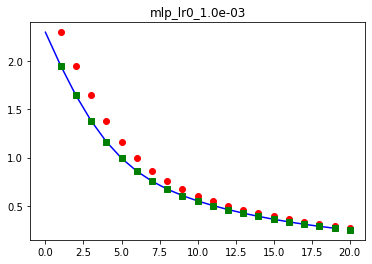

In [33]:
lossesTR
dlossesTR[test_name]    = lossesTR
dlossesTRAll[test_name] = lossesTRAll
dlossesTE[test_name]    = lossesTE
didxEpoch[test_name]    = idxEpoch
dbestAcc[test_name]     = bestAcc
dnbParam[test_name]     = count_parameters(net)
print('test')
#for n in ['convnet', 'CNN2']:
for n in [ test_name ]: # ajouter dans cette liste le nom des reseaux que vous tester 
    if n in dlossesTR:
        print ('----------------------------------------------------------------------------')
        print ('----------------------------------------------------------------------------')
        print ('----------------------------------------------------------------------------')
        print (n)
        print ('best accuracy      : '+str(dbestAcc[n].item()))
        print ('best loss on train : '+str(np.min(dlossesTR[n])) + ' idx '+str(np.argmin(dlossesTR[n])))
        print ('best loss on test  : '+str(np.min(dlossesTE[n])) + ' idx '+str(np.argmin(dlossesTE[n])))
        print ('n param            : '+str(dnbParam[n]))

        # evenly sampled time at 200ms intervals
        t = np.arange(0, len(dlossesTRAll[n]))
        print('test')
        plt.plot(t, dlossesTRAll[n], 'b', didxEpoch[n][1:], dlossesTR[n], 'ro', didxEpoch[n][1:], dlossesTE[n], 'gs')
        plt.title(n)
        plt.show()